<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_for_odd_sized_images_ver19%20Trainable%20D%20after%20Compile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [0]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,154 kB of

In [0]:
!pip install pydot pydot-ng


In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
#os._exit(0)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

In [0]:
def load_large_data():
    (X_train1, ytrain1), (_, _) = mnist.load_data()
    (X_train2, ytrain2), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([100000,28,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 1000):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*1000 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 600])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_dataPaired():
    
    (X_train1, ytrain1), (_, _) = mnist.load_data()
    (X_train1, ytrain1), (_, _) = fashion_mnist.load_data()

    (X_train2, ytrain2), (_, _) = fashion_mnist.load_data()
    
    X_train1label0 = np.zeros([10000,28,28],dtype=np.uint8)
    X_train1label1 = np.zeros([10000,28,28],dtype=np.uint8)
    X_train1label2 = np.zeros([10000,28,28],dtype=np.uint8)
    X_train1label3 = np.zeros([10000,28,28],dtype=np.uint8)
    
    
    count0 = 0 
    count1 = 1
    count2 = 2 
    count3 = 3
    for i in range(0, 50000):
      if(ytrain1[i]==0):
        X_train1label0[count0] = X_train1[i]
        count0 = count0 +1 
      if(ytrain1[i]==1):
        X_train1label1[count1] = X_train1[i]
        count1 = count1 +1
      if(ytrain1[i]==2):
        X_train1label2[count2] = X_train1[i]
        count2 = count2 +1
      if(ytrain1[i]==3):
        X_train1label3[count3] = X_train1[i]
        count3 = count3 +1
        
    
    totalsamples = 50000
    X_trainlarge = np.zeros([50000,28,56],dtype=np.uint8)
    
    fillount = 0
    for i in range(0, 10000): 
          if( (fillount + 3) > totalsamples  ):
            break
          aimage1 = X_train1label0[i]
          aimage2 = X_train1label1[i]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage2
          X_trainlarge[fillount] = largeimage
          fillount = fillount + 1
          aimage1 = X_train1label1[i]
          aimage2 = X_train1label2[i]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage2
          X_trainlarge[fillount] = largeimage
          fillount = fillount + 1          
          aimage1 = X_train1label2[i]
          aimage2 = X_train1label3[i]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage2
          X_trainlarge[fillount] = largeimage
          fillount = fillount + 1 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*10 + j + 14700])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)

    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_data5656():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(100000, 28, 56)


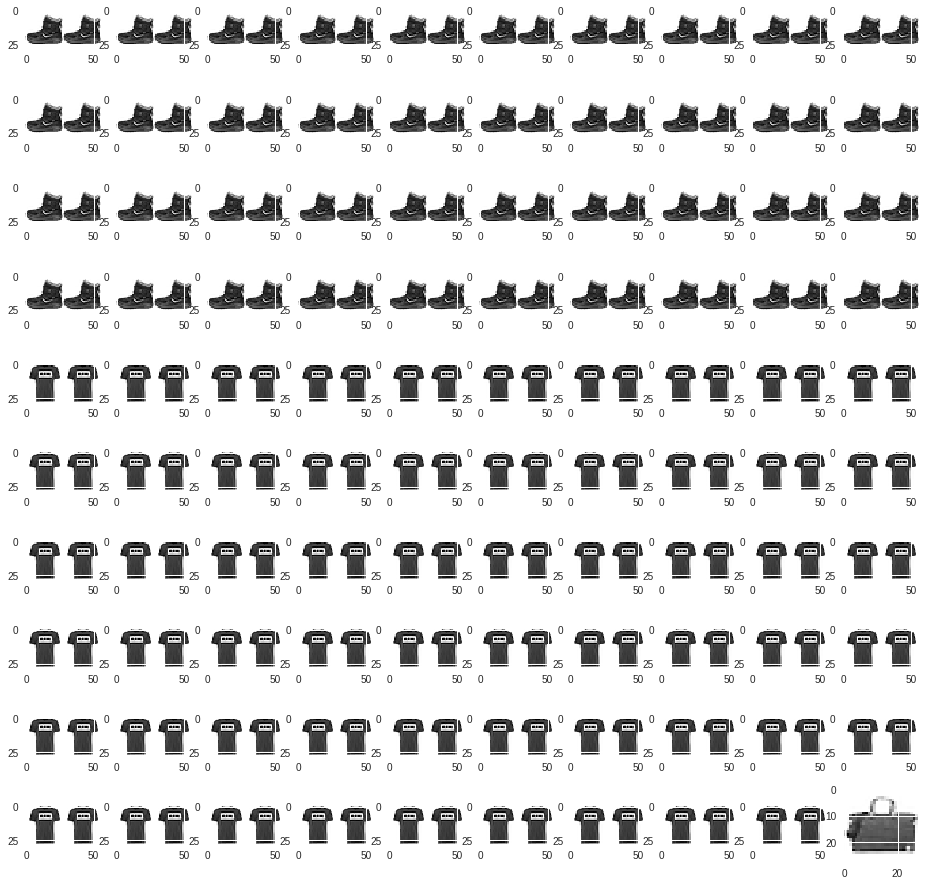

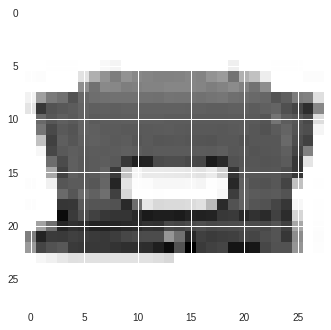

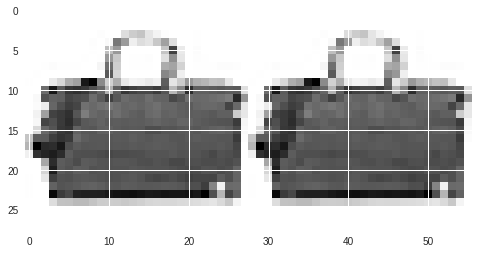

In [0]:
X_trainlarge = load_large_data()

In [0]:
#X_trainlarge5656 = load_large_data5656()

(60000, 28, 28)
(50000, 28, 56)


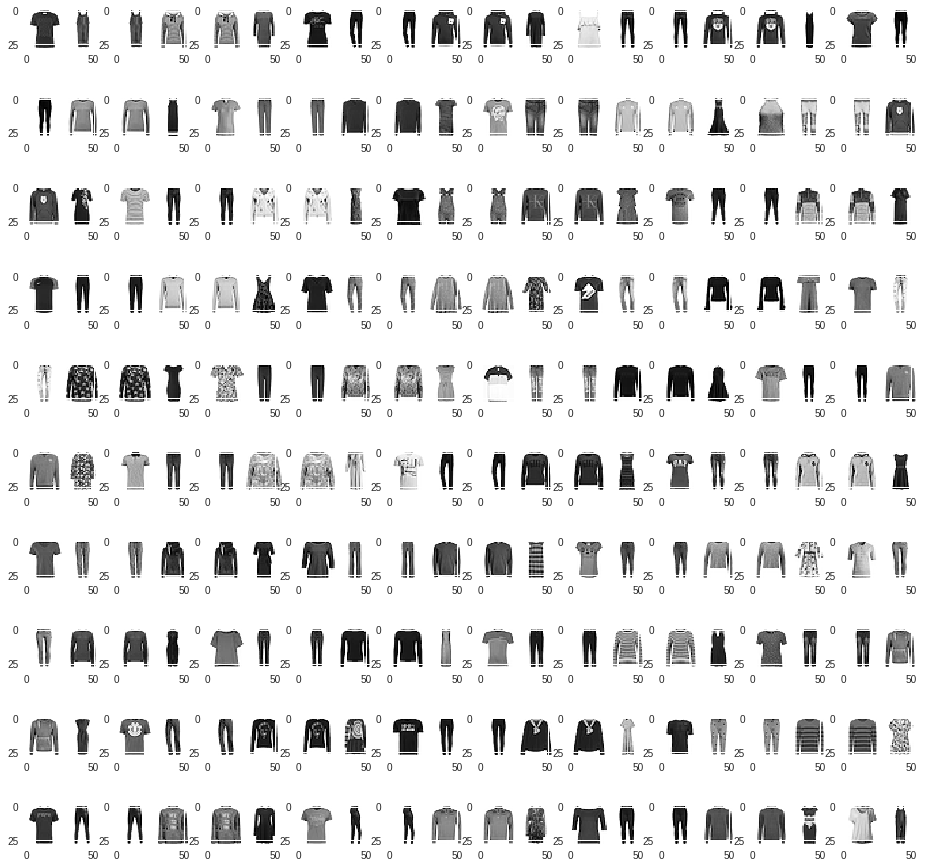

In [0]:
X_trainlargepaired = load_large_dataPaired()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  if (datasetname == 3):   
     X_train = X_trainlarge
  if (datasetname == 4):   
     X_train = X_trainlarge5656
  if (datasetname == 5):   
     X_train = X_trainlargepaired
      
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
  #  print("-- Discriminator -- ")
   # model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def save_imgs_all(generator1, generator2, generator3, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator1.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()
    
    gen_imgs = generator2.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()
    
    gen_imgs = generator3.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    #Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
   # Image(retina=True, filename='modelsmall.png')

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_modelsNandriNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 56, 1))
#    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    for obj1 in outputs:
      print(type(obj1))
      print(obj1.shape)
        
    mergedlayer = Concatenate(axis=2)(outputs)
    ##x = merge([lstm_out, auxiliary_input], mode='concat')
   ## output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
  #  mergedlayer = merge([generator1, generator2], mode='concat', concat_axis=1)
  
   #mergedlayer = merge([out1, out], mode='concat', concat_axis=1)
#contact axis can be -1 to 0 , 1 for inception , 2 , 3 or remove it
  #  mergedlayer = merge([generator1, generator1])

    print('merge layers')
    print(out1.shape)
    print(out.shape)
    print(mergedlayer.shape)

  

    
    
    mergedmodel = Model(z, mergedlayer)
    
    discriminator.trainable = False
    real = discriminator(mergedlayer)
    combined = Model(z, real)
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
  
        

    
    if(loadpretrainedweights==True):
      generator1.load_weights('my_model_weights_mnistver2.h5')
      #generator2.load_weights('my_model_weights_mnist.h5')
      #generator1 = load_model('generator2fmnist.h5')
      #generator2 = load_model('generator2fmnist.h5')
      

    generator1.trainable = False
    
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
   # plotamodel(mergedmodel)
   # plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)
    X_train5656 = None

    
    if modeltotrain == 3:
          X_train5656 = load_databydatasetname(3)
         # X_train = load_databydatasetname(5)

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
        
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              noise2 = copy.deepcopy(noise1)
              fake_images3 = mergedmodel.predict(noise2)
              fake_labels3 = np.zeros((half_batch, 1))    
              fake_images = fake_images3
              fake_labels = fake_labels3              
            


            X_train = X_trainlarge
            X_train = X_trainlargepaired
            #X_train = X_train5656
            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)            
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)
              print("real images")
              print(real_images.shape)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs_all(generator1, generator2, mergedmodel,  epoch, batch)
            #if batch % 101 == 0:
                 #save_imgs(generator2, epoch, batch)
            #if batch % 102 == 0:
                 #save_imgs(mergedmodel, epoch, batch)
                








In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)




    
    

    


<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 28, 28, 1)
merge layers
(?, 28, 28, 1)
(?, 28, 28, 1)
(?, 28, 56, 1)


In [0]:
plotamodel(mergedmodel)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 6272)         633472      input_9[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 6272)         633472      input_9[0][0]                    
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 7, 7, 128)    0           dense_13[0][0]                   
__________________________________________________________________________________________________
reshape_10

ImportError: ignored

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5
!wget https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnistver2.h5

  

--2018-12-07 00:59:20--  https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rajagopalmotivate/try1/master/my_model_weights_mnist.h5 [following]
--2018-12-07 00:59:20--  https://raw.githubusercontent.com/rajagopalmotivate/try1/master/my_model_weights_mnist.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3460672 (3.3M) [application/octet-stream]
Saving to: ‘my_model_weights_mnist.h5’

my_model_weights_mn 100%[===================>]   3.30M  --.-KB/s    in 0.08s   

2018-12-07 00:59:21 (39.9 MB/s) - ‘my_mod

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
plotamodel(discriminator)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=10, modeltotrain=1)

Number of examples:  60000
Number of Batches:  1875
Number of epochs:  1
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 56, 1)
real images
(16, 28, 56, 1)
Epoch 0 Batch 0/1875 [D loss: 0.926882, acc.: 34.38%] [G loss: 0.823565]


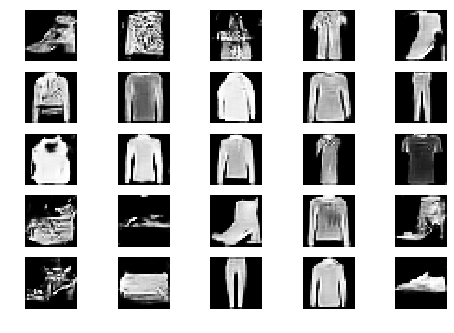

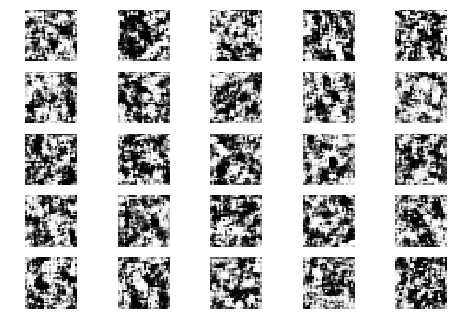

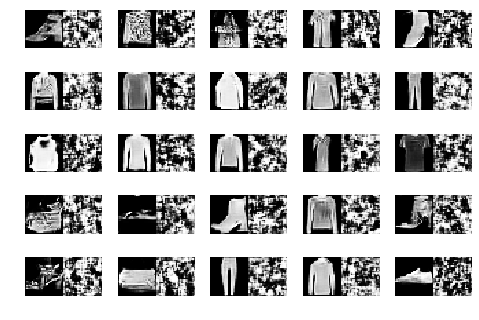

Epoch 0 Batch 1/1875 [D loss: 0.875045, acc.: 28.12%] [G loss: 0.793271]
Epoch 0 Batch 2/1875 [D loss: 0.828794, acc.: 40.62%] [G loss: 0.836958]
Epoch 0 Batch 3/1875 [D loss: 0.939079, acc.: 31.25%] [G loss: 0.763602]
Epoch 0 Batch 4/1875 [D loss: 0.964544, acc.: 34.38%] [G loss: 0.828508]
Epoch 0 Batch 5/1875 [D loss: 0.895481, acc.: 37.50%] [G loss: 0.799273]
Epoch 0 Batch 6/1875 [D loss: 0.811595, acc.: 40.62%] [G loss: 0.718423]
Epoch 0 Batch 7/1875 [D loss: 0.938111, acc.: 40.62%] [G loss: 0.736829]
Epoch 0 Batch 8/1875 [D loss: 0.872766, acc.: 40.62%] [G loss: 0.660166]
Epoch 0 Batch 9/1875 [D loss: 0.948029, acc.: 28.12%] [G loss: 0.692868]
Epoch 0 Batch 10/1875 [D loss: 0.903849, acc.: 37.50%] [G loss: 0.664372]
Epoch 0 Batch 11/1875 [D loss: 0.888979, acc.: 50.00%] [G loss: 0.614423]
Epoch 0 Batch 12/1875 [D loss: 0.985536, acc.: 21.88%] [G loss: 0.553274]
Epoch 0 Batch 13/1875 [D loss: 1.017336, acc.: 25.00%] [G loss: 0.557383]
Epoch 0 Batch 14/1875 [D loss: 0.924095, acc.: 

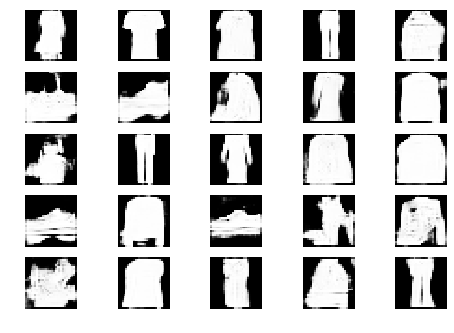

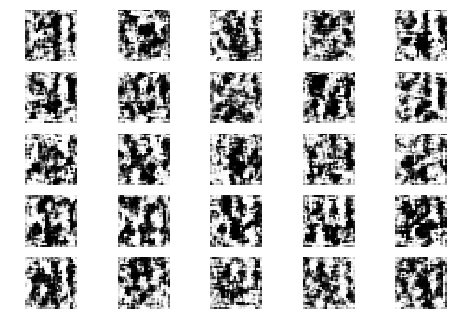

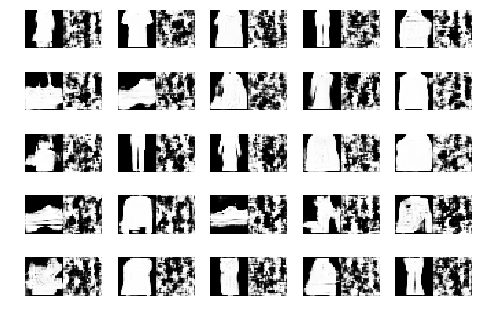

Epoch 0 Batch 101/1875 [D loss: 1.500849, acc.: 15.62%] [G loss: 0.190321]
Epoch 0 Batch 102/1875 [D loss: 1.513225, acc.: 15.62%] [G loss: 0.190764]
Epoch 0 Batch 103/1875 [D loss: 1.633112, acc.: 6.25%] [G loss: 0.222692]
Epoch 0 Batch 104/1875 [D loss: 1.558014, acc.: 15.62%] [G loss: 0.203265]
Epoch 0 Batch 105/1875 [D loss: 1.520792, acc.: 15.62%] [G loss: 0.170048]
Epoch 0 Batch 106/1875 [D loss: 1.437435, acc.: 28.12%] [G loss: 0.124335]
Epoch 0 Batch 107/1875 [D loss: 1.679981, acc.: 25.00%] [G loss: 0.169979]
Epoch 0 Batch 108/1875 [D loss: 1.699915, acc.: 6.25%] [G loss: 0.161670]
Epoch 0 Batch 109/1875 [D loss: 1.559149, acc.: 15.62%] [G loss: 0.134247]
Epoch 0 Batch 110/1875 [D loss: 1.591075, acc.: 12.50%] [G loss: 0.174008]
Epoch 0 Batch 111/1875 [D loss: 1.713775, acc.: 6.25%] [G loss: 0.134201]
Epoch 0 Batch 112/1875 [D loss: 1.725304, acc.: 3.12%] [G loss: 0.115980]
Epoch 0 Batch 113/1875 [D loss: 1.647892, acc.: 12.50%] [G loss: 0.155525]
Epoch 0 Batch 114/1875 [D los

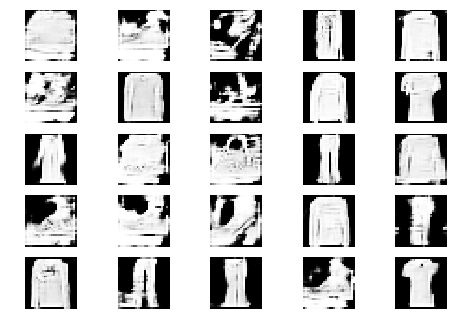

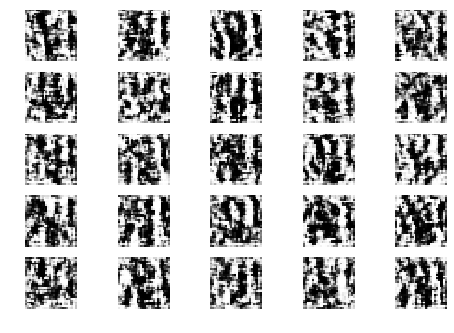

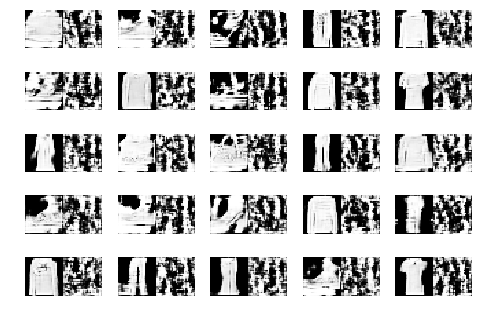

Epoch 0 Batch 201/1875 [D loss: 1.832819, acc.: 21.88%] [G loss: 0.077912]
Epoch 0 Batch 202/1875 [D loss: 1.922767, acc.: 12.50%] [G loss: 0.098750]
Epoch 0 Batch 203/1875 [D loss: 1.836044, acc.: 18.75%] [G loss: 0.072199]
Epoch 0 Batch 204/1875 [D loss: 1.881343, acc.: 12.50%] [G loss: 0.069923]
Epoch 0 Batch 205/1875 [D loss: 1.913524, acc.: 12.50%] [G loss: 0.081591]
Epoch 0 Batch 206/1875 [D loss: 1.786511, acc.: 21.88%] [G loss: 0.072667]
Epoch 0 Batch 207/1875 [D loss: 1.771871, acc.: 15.62%] [G loss: 0.089364]
Epoch 0 Batch 208/1875 [D loss: 1.744481, acc.: 15.62%] [G loss: 0.079474]
Epoch 0 Batch 209/1875 [D loss: 1.894402, acc.: 6.25%] [G loss: 0.078388]
Epoch 0 Batch 210/1875 [D loss: 1.805624, acc.: 12.50%] [G loss: 0.082925]
Epoch 0 Batch 211/1875 [D loss: 1.999636, acc.: 18.75%] [G loss: 0.068687]
Epoch 0 Batch 212/1875 [D loss: 2.050897, acc.: 9.38%] [G loss: 0.092496]
Epoch 0 Batch 213/1875 [D loss: 1.948975, acc.: 9.38%] [G loss: 0.085605]
Epoch 0 Batch 214/1875 [D lo

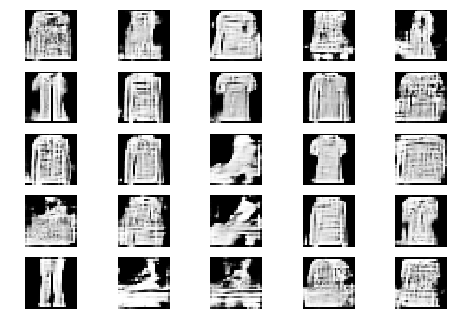

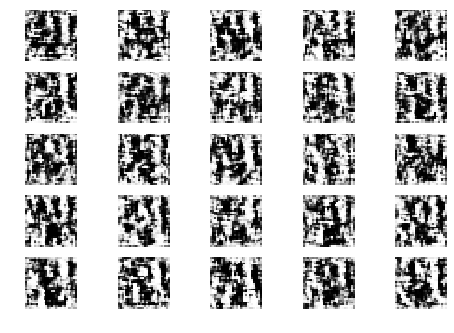

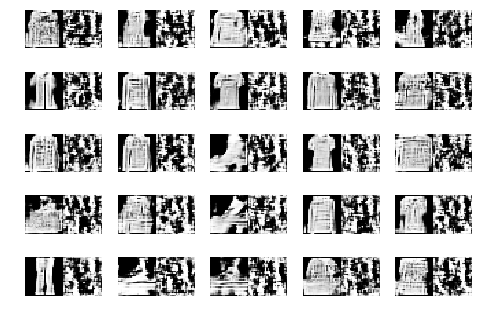

Epoch 0 Batch 301/1875 [D loss: 2.273272, acc.: 9.38%] [G loss: 0.048834]
Epoch 0 Batch 302/1875 [D loss: 2.074745, acc.: 15.62%] [G loss: 0.052096]
Epoch 0 Batch 303/1875 [D loss: 2.295293, acc.: 9.38%] [G loss: 0.056410]
Epoch 0 Batch 304/1875 [D loss: 2.141138, acc.: 12.50%] [G loss: 0.045078]
Epoch 0 Batch 305/1875 [D loss: 2.268888, acc.: 12.50%] [G loss: 0.058017]
Epoch 0 Batch 306/1875 [D loss: 2.248730, acc.: 21.88%] [G loss: 0.059380]
Epoch 0 Batch 307/1875 [D loss: 2.192870, acc.: 6.25%] [G loss: 0.056871]
Epoch 0 Batch 308/1875 [D loss: 2.242707, acc.: 9.38%] [G loss: 0.045784]
Epoch 0 Batch 309/1875 [D loss: 2.066298, acc.: 15.62%] [G loss: 0.043054]
Epoch 0 Batch 310/1875 [D loss: 2.058466, acc.: 21.88%] [G loss: 0.052040]
Epoch 0 Batch 311/1875 [D loss: 2.204616, acc.: 15.62%] [G loss: 0.044967]
Epoch 0 Batch 312/1875 [D loss: 2.165769, acc.: 21.88%] [G loss: 0.042401]
Epoch 0 Batch 313/1875 [D loss: 2.006829, acc.: 18.75%] [G loss: 0.042465]
Epoch 0 Batch 314/1875 [D los

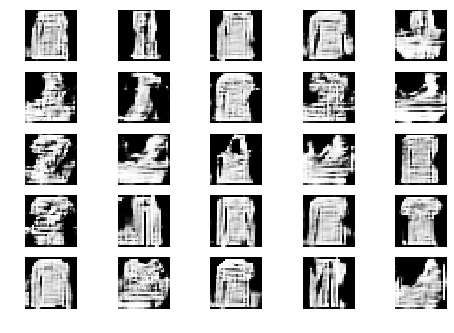

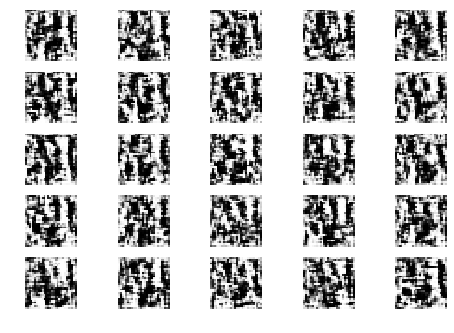

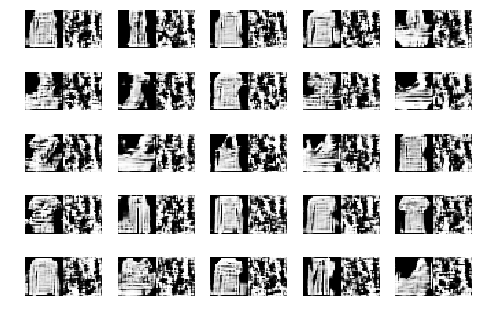

Epoch 0 Batch 401/1875 [D loss: 2.269505, acc.: 6.25%] [G loss: 0.039227]
Epoch 0 Batch 402/1875 [D loss: 2.401104, acc.: 15.62%] [G loss: 0.032765]
Epoch 0 Batch 403/1875 [D loss: 2.256478, acc.: 15.62%] [G loss: 0.031688]
Epoch 0 Batch 404/1875 [D loss: 2.287071, acc.: 12.50%] [G loss: 0.028542]
Epoch 0 Batch 405/1875 [D loss: 2.563094, acc.: 15.62%] [G loss: 0.029737]
Epoch 0 Batch 406/1875 [D loss: 2.537206, acc.: 9.38%] [G loss: 0.031478]
Epoch 0 Batch 407/1875 [D loss: 2.188790, acc.: 15.62%] [G loss: 0.031234]
Epoch 0 Batch 408/1875 [D loss: 2.487167, acc.: 15.62%] [G loss: 0.030612]
Epoch 0 Batch 409/1875 [D loss: 2.502605, acc.: 15.62%] [G loss: 0.025246]
Epoch 0 Batch 410/1875 [D loss: 2.261839, acc.: 21.88%] [G loss: 0.028843]
Epoch 0 Batch 411/1875 [D loss: 2.350124, acc.: 15.62%] [G loss: 0.034586]
Epoch 0 Batch 412/1875 [D loss: 2.421387, acc.: 3.12%] [G loss: 0.030159]
Epoch 0 Batch 413/1875 [D loss: 2.505917, acc.: 9.38%] [G loss: 0.037996]
Epoch 0 Batch 414/1875 [D los

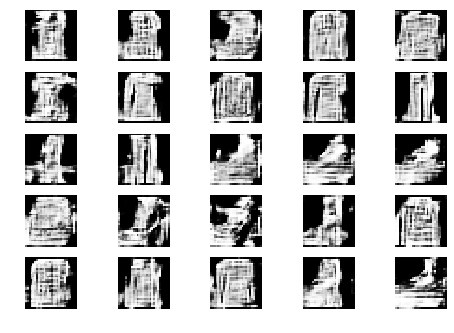

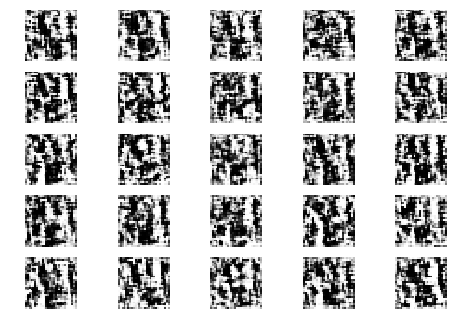

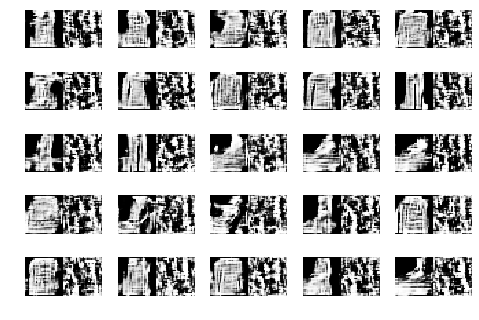

Epoch 0 Batch 501/1875 [D loss: 2.399161, acc.: 18.75%] [G loss: 0.021130]
Epoch 0 Batch 502/1875 [D loss: 2.415442, acc.: 12.50%] [G loss: 0.024710]
Epoch 0 Batch 503/1875 [D loss: 2.443430, acc.: 15.62%] [G loss: 0.020867]
Epoch 0 Batch 504/1875 [D loss: 2.643272, acc.: 12.50%] [G loss: 0.028469]
Epoch 0 Batch 505/1875 [D loss: 2.235165, acc.: 25.00%] [G loss: 0.024059]
Epoch 0 Batch 506/1875 [D loss: 2.528447, acc.: 12.50%] [G loss: 0.027182]
Epoch 0 Batch 507/1875 [D loss: 2.348805, acc.: 21.88%] [G loss: 0.019760]
Epoch 0 Batch 508/1875 [D loss: 2.609208, acc.: 15.62%] [G loss: 0.023957]
Epoch 0 Batch 509/1875 [D loss: 2.889662, acc.: 12.50%] [G loss: 0.029878]
Epoch 0 Batch 510/1875 [D loss: 2.455369, acc.: 18.75%] [G loss: 0.022720]
Epoch 0 Batch 511/1875 [D loss: 2.862082, acc.: 6.25%] [G loss: 0.022999]
Epoch 0 Batch 512/1875 [D loss: 2.578367, acc.: 3.12%] [G loss: 0.019916]
Epoch 0 Batch 513/1875 [D loss: 2.509646, acc.: 9.38%] [G loss: 0.024396]
Epoch 0 Batch 514/1875 [D lo

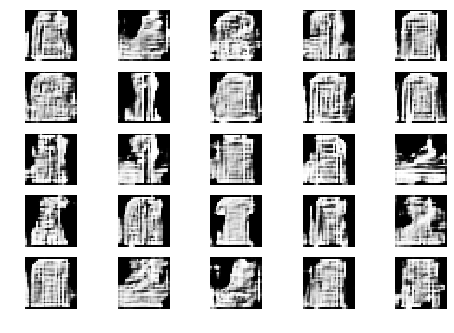

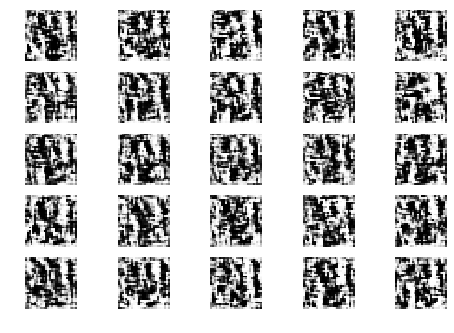

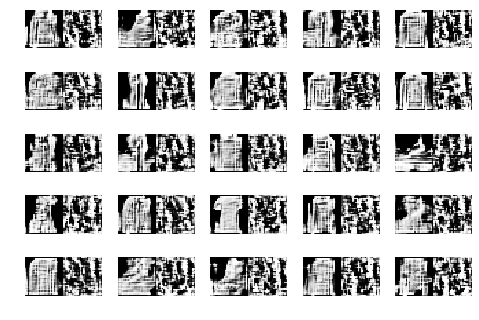

Epoch 0 Batch 601/1875 [D loss: 2.689882, acc.: 15.62%] [G loss: 0.020633]
Epoch 0 Batch 602/1875 [D loss: 2.705414, acc.: 21.88%] [G loss: 0.021508]
Epoch 0 Batch 603/1875 [D loss: 2.613890, acc.: 9.38%] [G loss: 0.018336]
Epoch 0 Batch 604/1875 [D loss: 2.775232, acc.: 9.38%] [G loss: 0.023151]
Epoch 0 Batch 605/1875 [D loss: 2.630691, acc.: 18.75%] [G loss: 0.018285]
Epoch 0 Batch 606/1875 [D loss: 2.683650, acc.: 15.62%] [G loss: 0.016948]
Epoch 0 Batch 607/1875 [D loss: 2.664507, acc.: 12.50%] [G loss: 0.021709]
Epoch 0 Batch 608/1875 [D loss: 2.615496, acc.: 12.50%] [G loss: 0.020009]
Epoch 0 Batch 609/1875 [D loss: 2.762401, acc.: 9.38%] [G loss: 0.021265]
Epoch 0 Batch 610/1875 [D loss: 2.741096, acc.: 9.38%] [G loss: 0.017899]
Epoch 0 Batch 611/1875 [D loss: 2.707039, acc.: 12.50%] [G loss: 0.017765]
Epoch 0 Batch 612/1875 [D loss: 2.692652, acc.: 9.38%] [G loss: 0.015228]
Epoch 0 Batch 613/1875 [D loss: 2.890718, acc.: 9.38%] [G loss: 0.014956]
Epoch 0 Batch 614/1875 [D loss:

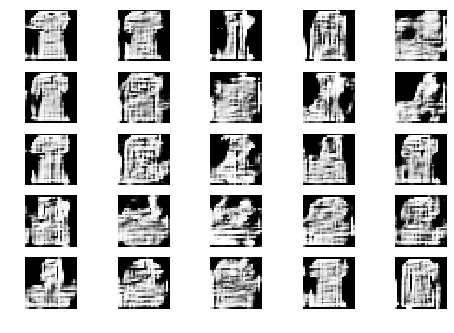

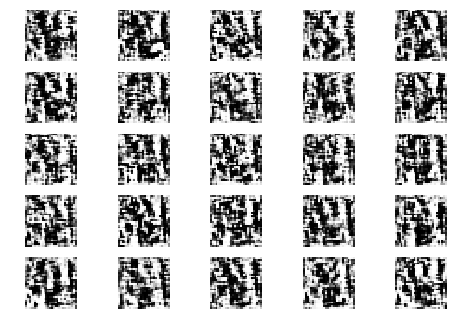

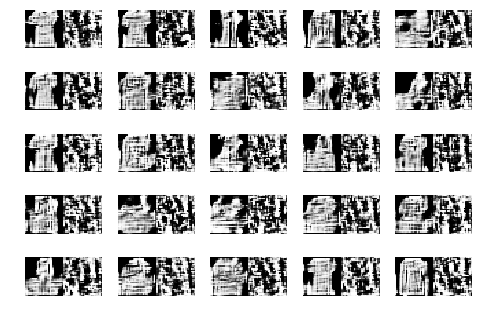

Epoch 0 Batch 701/1875 [D loss: 2.741028, acc.: 12.50%] [G loss: 0.014774]
Epoch 0 Batch 702/1875 [D loss: 2.770523, acc.: 3.12%] [G loss: 0.014536]
Epoch 0 Batch 703/1875 [D loss: 2.696141, acc.: 12.50%] [G loss: 0.014382]
Epoch 0 Batch 704/1875 [D loss: 2.819877, acc.: 12.50%] [G loss: 0.013476]
Epoch 0 Batch 705/1875 [D loss: 2.823416, acc.: 12.50%] [G loss: 0.012005]
Epoch 0 Batch 706/1875 [D loss: 2.856030, acc.: 9.38%] [G loss: 0.017636]
Epoch 0 Batch 707/1875 [D loss: 2.800472, acc.: 9.38%] [G loss: 0.019221]
Epoch 0 Batch 708/1875 [D loss: 2.418794, acc.: 15.62%] [G loss: 0.016402]
Epoch 0 Batch 709/1875 [D loss: 2.721584, acc.: 15.62%] [G loss: 0.016210]
Epoch 0 Batch 710/1875 [D loss: 2.785542, acc.: 12.50%] [G loss: 0.015313]
Epoch 0 Batch 711/1875 [D loss: 2.767817, acc.: 21.88%] [G loss: 0.016172]
Epoch 0 Batch 712/1875 [D loss: 2.680665, acc.: 25.00%] [G loss: 0.013570]
Epoch 0 Batch 713/1875 [D loss: 2.836536, acc.: 12.50%] [G loss: 0.015297]
Epoch 0 Batch 714/1875 [D lo

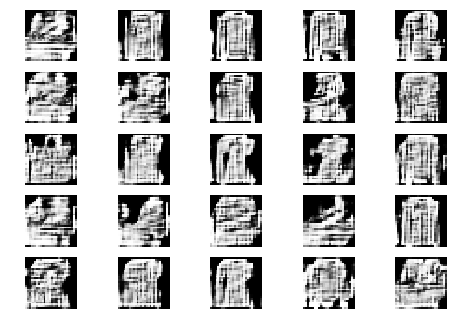

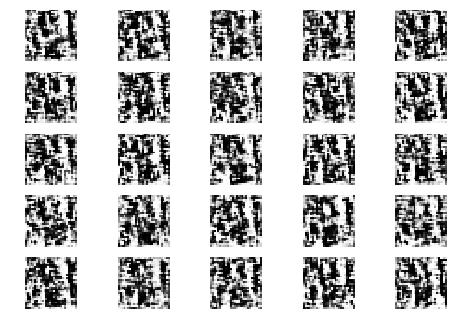

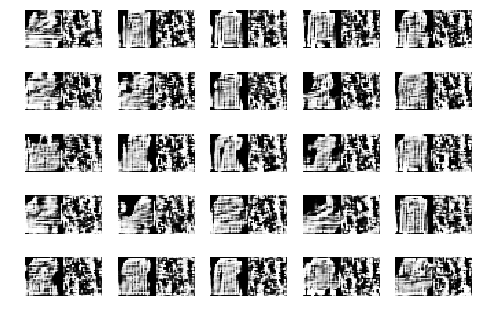

Epoch 0 Batch 801/1875 [D loss: 2.857449, acc.: 21.88%] [G loss: 0.009605]
Epoch 0 Batch 802/1875 [D loss: 2.772403, acc.: 15.62%] [G loss: 0.011518]
Epoch 0 Batch 803/1875 [D loss: 2.950908, acc.: 6.25%] [G loss: 0.012483]
Epoch 0 Batch 804/1875 [D loss: 2.658540, acc.: 6.25%] [G loss: 0.013207]
Epoch 0 Batch 805/1875 [D loss: 2.989088, acc.: 12.50%] [G loss: 0.012053]
Epoch 0 Batch 806/1875 [D loss: 2.937204, acc.: 6.25%] [G loss: 0.012352]
Epoch 0 Batch 807/1875 [D loss: 2.955842, acc.: 9.38%] [G loss: 0.016869]
Epoch 0 Batch 808/1875 [D loss: 3.210494, acc.: 12.50%] [G loss: 0.012143]
Epoch 0 Batch 809/1875 [D loss: 2.775764, acc.: 18.75%] [G loss: 0.013978]
Epoch 0 Batch 810/1875 [D loss: 2.742664, acc.: 12.50%] [G loss: 0.013609]
Epoch 0 Batch 811/1875 [D loss: 2.960560, acc.: 18.75%] [G loss: 0.014389]
Epoch 0 Batch 812/1875 [D loss: 2.769301, acc.: 21.88%] [G loss: 0.013502]
Epoch 0 Batch 813/1875 [D loss: 2.737728, acc.: 21.88%] [G loss: 0.009477]
Epoch 0 Batch 814/1875 [D los

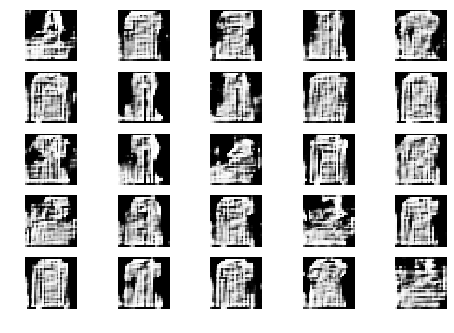

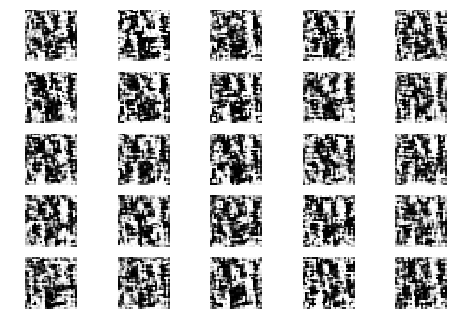

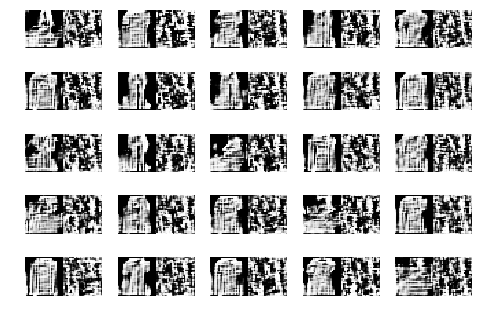

Epoch 0 Batch 901/1875 [D loss: 2.986472, acc.: 15.62%] [G loss: 0.009026]
Epoch 0 Batch 902/1875 [D loss: 2.797220, acc.: 6.25%] [G loss: 0.008843]
Epoch 0 Batch 903/1875 [D loss: 3.001816, acc.: 9.38%] [G loss: 0.010398]
Epoch 0 Batch 904/1875 [D loss: 2.885120, acc.: 15.62%] [G loss: 0.011728]
Epoch 0 Batch 905/1875 [D loss: 3.023899, acc.: 12.50%] [G loss: 0.010291]
Epoch 0 Batch 906/1875 [D loss: 2.887743, acc.: 18.75%] [G loss: 0.011398]
Epoch 0 Batch 907/1875 [D loss: 2.811520, acc.: 18.75%] [G loss: 0.010583]
Epoch 0 Batch 908/1875 [D loss: 2.916414, acc.: 21.88%] [G loss: 0.010798]
Epoch 0 Batch 909/1875 [D loss: 2.931406, acc.: 21.88%] [G loss: 0.012177]
Epoch 0 Batch 910/1875 [D loss: 2.875077, acc.: 12.50%] [G loss: 0.011878]
Epoch 0 Batch 911/1875 [D loss: 3.063754, acc.: 0.00%] [G loss: 0.011790]
Epoch 0 Batch 912/1875 [D loss: 2.951816, acc.: 6.25%] [G loss: 0.012408]
Epoch 0 Batch 913/1875 [D loss: 2.917785, acc.: 6.25%] [G loss: 0.011913]
Epoch 0 Batch 914/1875 [D loss

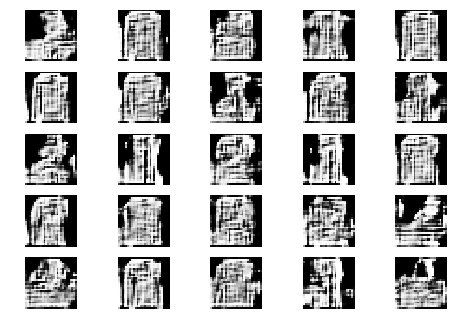

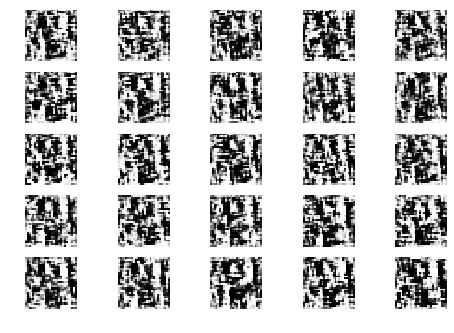

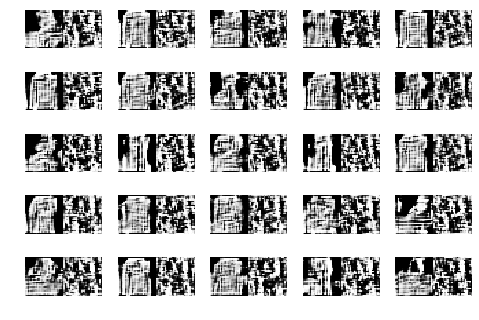

Epoch 0 Batch 1001/1875 [D loss: 3.264067, acc.: 12.50%] [G loss: 0.008655]
Epoch 0 Batch 1002/1875 [D loss: 3.208596, acc.: 9.38%] [G loss: 0.012551]
Epoch 0 Batch 1003/1875 [D loss: 3.015502, acc.: 15.62%] [G loss: 0.009654]
Epoch 0 Batch 1004/1875 [D loss: 3.010095, acc.: 9.38%] [G loss: 0.009320]
Epoch 0 Batch 1005/1875 [D loss: 3.120553, acc.: 12.50%] [G loss: 0.007852]
Epoch 0 Batch 1006/1875 [D loss: 2.915848, acc.: 15.62%] [G loss: 0.008688]
Epoch 0 Batch 1007/1875 [D loss: 3.204757, acc.: 6.25%] [G loss: 0.007762]
Epoch 0 Batch 1008/1875 [D loss: 2.932742, acc.: 18.75%] [G loss: 0.006709]
Epoch 0 Batch 1009/1875 [D loss: 3.191028, acc.: 6.25%] [G loss: 0.009332]
Epoch 0 Batch 1010/1875 [D loss: 3.069398, acc.: 15.62%] [G loss: 0.009695]
Epoch 0 Batch 1011/1875 [D loss: 3.142366, acc.: 18.75%] [G loss: 0.008558]
Epoch 0 Batch 1012/1875 [D loss: 3.092480, acc.: 9.38%] [G loss: 0.010908]
Epoch 0 Batch 1013/1875 [D loss: 3.072113, acc.: 12.50%] [G loss: 0.011329]
Epoch 0 Batch 101

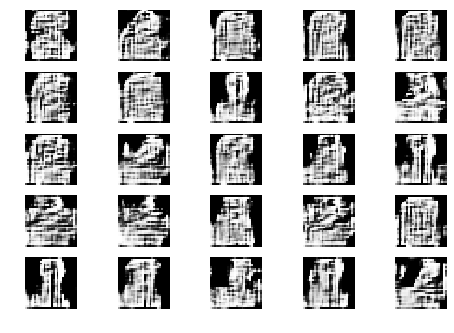

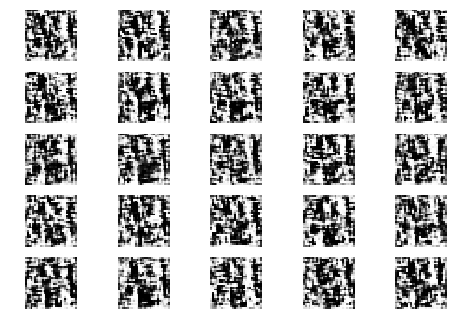

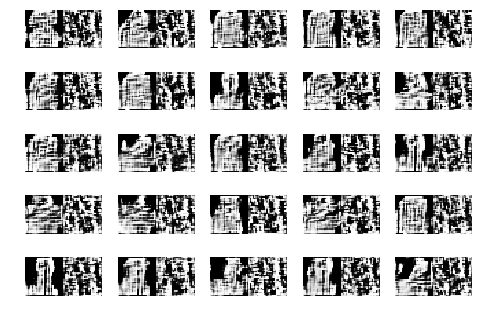

Epoch 0 Batch 1101/1875 [D loss: 3.034978, acc.: 15.62%] [G loss: 0.009208]
Epoch 0 Batch 1102/1875 [D loss: 2.976703, acc.: 6.25%] [G loss: 0.008508]
Epoch 0 Batch 1103/1875 [D loss: 3.114780, acc.: 12.50%] [G loss: 0.007620]
Epoch 0 Batch 1104/1875 [D loss: 2.874844, acc.: 9.38%] [G loss: 0.007185]
Epoch 0 Batch 1105/1875 [D loss: 2.766414, acc.: 12.50%] [G loss: 0.007954]
Epoch 0 Batch 1106/1875 [D loss: 3.191475, acc.: 9.38%] [G loss: 0.007557]
Epoch 0 Batch 1107/1875 [D loss: 2.844536, acc.: 21.88%] [G loss: 0.009462]
Epoch 0 Batch 1108/1875 [D loss: 3.202846, acc.: 15.62%] [G loss: 0.006954]
Epoch 0 Batch 1109/1875 [D loss: 2.883524, acc.: 25.00%] [G loss: 0.005823]
Epoch 0 Batch 1110/1875 [D loss: 3.023587, acc.: 18.75%] [G loss: 0.007561]
Epoch 0 Batch 1111/1875 [D loss: 3.224655, acc.: 12.50%] [G loss: 0.006304]
Epoch 0 Batch 1112/1875 [D loss: 3.096943, acc.: 12.50%] [G loss: 0.005777]
Epoch 0 Batch 1113/1875 [D loss: 2.996501, acc.: 12.50%] [G loss: 0.008077]
Epoch 0 Batch 1

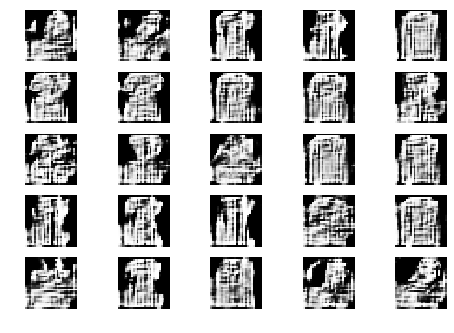

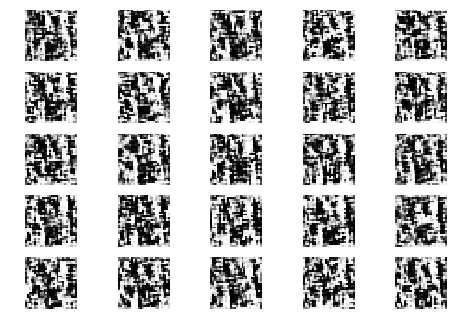

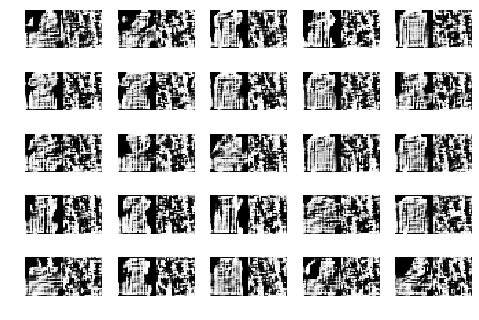

Epoch 0 Batch 1201/1875 [D loss: 3.507471, acc.: 3.12%] [G loss: 0.006820]
Epoch 0 Batch 1202/1875 [D loss: 3.039870, acc.: 25.00%] [G loss: 0.006192]
Epoch 0 Batch 1203/1875 [D loss: 3.183947, acc.: 9.38%] [G loss: 0.005980]
Epoch 0 Batch 1204/1875 [D loss: 3.268802, acc.: 15.62%] [G loss: 0.006872]
Epoch 0 Batch 1205/1875 [D loss: 3.323590, acc.: 6.25%] [G loss: 0.006922]
Epoch 0 Batch 1206/1875 [D loss: 2.983991, acc.: 12.50%] [G loss: 0.006327]
Epoch 0 Batch 1207/1875 [D loss: 3.316234, acc.: 15.62%] [G loss: 0.006357]
Epoch 0 Batch 1208/1875 [D loss: 3.152268, acc.: 12.50%] [G loss: 0.007220]
Epoch 0 Batch 1209/1875 [D loss: 3.437224, acc.: 12.50%] [G loss: 0.007357]
Epoch 0 Batch 1210/1875 [D loss: 3.011566, acc.: 21.88%] [G loss: 0.007702]
Epoch 0 Batch 1211/1875 [D loss: 3.147759, acc.: 9.38%] [G loss: 0.007914]
Epoch 0 Batch 1212/1875 [D loss: 3.308700, acc.: 12.50%] [G loss: 0.006008]
Epoch 0 Batch 1213/1875 [D loss: 3.145225, acc.: 12.50%] [G loss: 0.006103]
Epoch 0 Batch 12

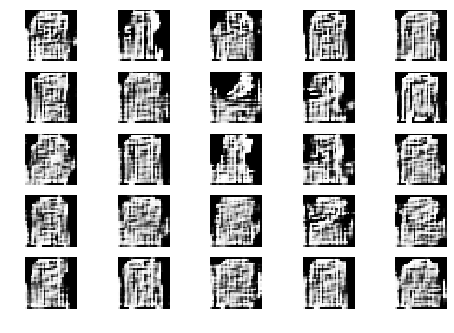

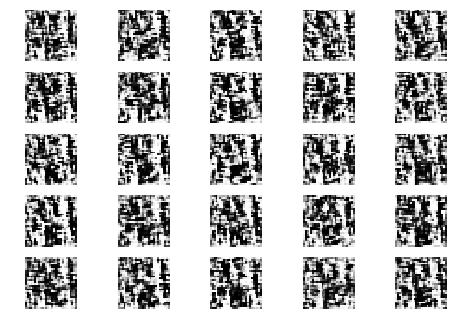

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 2 ,  loadpretrainedweights=True)




    
    

    


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=4, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=20, modeltotrain=3)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5
!rm -rf generator2fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator2fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')


In [0]:
generator2 = generator2.load_weights('generator1fminst.h5')




In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

